# Exploratory Data Analysis: preprocessing, data cleansing, statistical analysis and visualizations

### 1. import the necessary libraries for the analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 2. load data files and merge them into one DataFrame

Read college player statistics from 2009 to 2022. The data can be found in two different csv files, one contains stats from 2009 to 2021, while the other one contains the latest statistics (2022).

In [2]:
college1 = pd.read_csv('Data\CollegeBasketballPlayers2009-2021.csv',low_memory=False)
college2 = pd.read_csv('Data\CollegeBasketballPlayers2022.csv',low_memory=False)

The other data source contains draft picks at the nba draft for each year from 2009 to 2021.

In [3]:
draft = pd.read_excel('Data\DraftedPlayers2009-2021.xlsx')

First of all, lets concatenate the college statistical dataframes.

In [4]:
college = pd.concat([college1,college2])
print(college1.size+college2.size == college.size)

True


Since the draft data set has merged cells in the table header the first row must be dropped.

In [5]:
draft.drop(0,axis=0,inplace=True)

Rename the ROUND.1 column to PICK, and modify the PLAYER to player_name, so it can be act as a key during the join with the college data set.

In [6]:
draft.rename(
    columns={
        "PLAYER": "player_name", 
        "TEAM": "drafted_by", 
        "YEAR" : "year", 
        "ROUND" : "draft_round", 
        "ROUND.1" : "draft_pick"},
        inplace=True)

Convert all column names to lowcase letters.

In [7]:
draft.columns = draft.columns.str.lower()

Merge the college set with the draft data to identify those players who have been drafted after playing in college.

In [8]:
df = pd.merge(college,draft,how='left',on=['player_name','year'])

### 3. clean the data set and prepare it for statistical analyzis and further analytical steps

Create a new column to identify the drafted players.

In [9]:
df['drafted_flag'] = (~df.overall.isnull())*1

Since the draft data does not contain information about 2022, rows for 2022 should removed from the 'df' data set and saved into a new dataframe.

In [10]:
df_2022 = df[df.year == 2022]
df = df[df.year < 2022]

Rename unnamed column 64 for clearity.

In [11]:
df.rename(columns={'Unnamed: 64':'player_position'},inplace=True)

Drop unknown, irrelevant (not statistical, such as 'num': jersey number column) or dupplicate columns.

In [12]:
# find NaN or null values
print(df.isnull().sum().sort_values(ascending=False))

overall         60459
draft_pick      60459
draft_round     60459
affiliation     60459
drafted_by      60459
                ...  
adjoe               0
pfr                 0
year                0
pid                 0
drafted_flag        0
Length: 72, dtype: int64


In [13]:
# unknown with nan values
df = df.drop('Unnamed: 65', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('pick', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('overall', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('affiliation', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('draft_round', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('draft_pick', axis=1)
# irrelevant, not statistical data (jersey number)
df = df.drop('num', axis=1)
# irrelevant, not statistical data (player id in the database)
df = df.drop('pid', axis=1)
# irrelevant, not statistical data (unique value for all rows)
df = df.drop('type', axis=1)

Handle missing values.

In [14]:
df.drafted_flag.fillna(value=0, inplace=True)
df.yr.fillna(value='None', inplace=True)
df.player_position.fillna(value='None', inplace=True)

Check non integer columns and find the categorical values.

In [15]:
df_nonint = df.select_dtypes(exclude=['int64','float'])
df_nonint.columns

Index(['player_name', 'team', 'conf', 'yr', 'ht', 'player_position',
       'drafted_by', 'drafted_flag'],
      dtype='object')

In [16]:
df_nonint.nunique()

player_name        25719
team                 362
conf                  36
yr                     8
ht                    39
player_position        9
drafted_by            34
drafted_flag           2
dtype: int64

Check distinct values for object type 'yr' column.

In [17]:
print(df.yr.value_counts())

Jr      16241
Fr      16233
So      14485
Sr      13801
None      294
0           5
57.1        1
42.9        1
Name: yr, dtype: int64


Handle mistyped or wrong values.

In [18]:
df.yr.replace('0', 'None', inplace=True)
df.yr.replace('57.1', 'None', inplace=True)
df.yr.replace('42.9', 'None', inplace=True)

One hot encode categorical column: yr

In [19]:
df = pd.get_dummies(df, columns=['yr'])

Reorder columns to have drafted_flag as the last column of the dataframe.

In [20]:
col_list = df.columns.tolist()
col_list.pop(-6)  # 'drafted_flag'
col_list.append('drafted_flag')
df = df[col_list]

Check non-numeric columns.

In [21]:
print(df.dtypes.value_counts())
print(df.select_dtypes('object').columns)

float64    47
int64       8
object      6
uint8       5
int32       1
dtype: int64
Index(['player_name', 'team', 'conf', 'ht', 'player_position', 'drafted_by'], dtype='object')


Leave only numeric data and fill all remaining columns with zeros.

In [22]:
df = df.select_dtypes(exclude='object')
df.fillna(value=0, inplace=True)

Check data for the drafted_flag column.

In [23]:
print(df.groupby(['year','drafted_flag'])['drafted_flag'].count())

year  drafted_flag
2009  0               4542
      1                 47
2010  0               4645
      1                 53
2011  0               4502
      1                 46
2012  0               4535
      1                 51
2013  0               4566
      1                 42
2014  0               4679
      1                 43
2015  0               4681
      1                 43
2016  0               4656
      1                 41
2017  0               4695
      1                 48
2018  0               4661
      1                 42
2019  0               4692
      1                 48
2020  0               4685
      1                 48
2021  0               4920
      1                 50
Name: drafted_flag, dtype: int64


### 4. create visualizations and analyze statistics

Calculate basic statistics.

In [24]:
df.describe()

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,ast,stl,blk,pts,yr_Fr,yr_Jr,yr_None,yr_So,yr_Sr,drafted_flag
count,61061.000000,61061.00000,61061.000000,61061.000000,61061.000000,61061.000000,61061.00000,61061.000000,61061.000000,61061.000000,...,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000
mean,22.797760,37.12839,91.666396,18.126341,44.500768,47.584212,5.54225,12.704242,10.808699,20.225856,...,1.072110,0.529117,0.280821,5.769986,0.265849,0.265980,0.004929,0.237222,0.226020,0.009859
std,10.166805,28.05805,30.963736,6.253742,18.431761,17.640613,9.30561,10.755123,9.362704,12.318765,...,1.169619,0.469654,0.414815,4.948427,0.441788,0.441857,0.070038,0.425383,0.418256,0.098803
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,9.30000,83.900000,14.500000,40.000000,43.800000,1.80000,8.400000,4.600000,14.700000,...,0.222200,0.157900,0.000000,1.571400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,35.60000,97.100000,18.100000,47.700000,50.850000,4.30000,11.900000,9.000000,19.100000,...,0.677400,0.424200,0.133300,4.482800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,62.00000,106.900000,21.800000,53.300000,56.110000,8.10000,16.100000,15.000000,24.400000,...,1.533300,0.793100,0.363600,9.062500,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,98.00000,834.000000,50.000000,150.000000,150.000000,1576.60000,1385.000000,100.000000,100.000000,...,10.000000,4.000000,5.258100,30.090900,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Create correlation matrix.

In [25]:
corr_matrix = df.corr()
corr_matrix = corr_matrix[abs(corr_matrix) < 1]
corr_matrix = corr_matrix.stack().reset_index()
corr_matrix.columns = ['Variable1','Variable2','Correlation']
print(corr_matrix)

         Variable1 Variable2  Correlation
0               GP   Min_per     0.766095
1               GP      Ortg     0.436458
2               GP       usg     0.194152
3               GP       eFG     0.410425
4               GP    TS_per     0.428273
...            ...       ...          ...
3655  drafted_flag     yr_Fr    -0.003767
3656  drafted_flag     yr_Jr    -0.014300
3657  drafted_flag   yr_None    -0.007023
3658  drafted_flag     yr_So    -0.001873
3659  drafted_flag     yr_Sr     0.022168

[3660 rows x 3 columns]


Calculate the empirical distribution of the target feature per year.

In [26]:
drafted_per_year = df[df.drafted_flag == 1].groupby('year').count()['drafted_flag']
count_per_year = df.groupby('year').count()['GP']
yearly_drafts = drafted_per_year/count_per_year
print(yearly_drafts)

year
2009    0.010242
2010    0.011281
2011    0.010114
2012    0.011121
2013    0.009115
2014    0.009106
2015    0.009102
2016    0.008729
2017    0.010120
2018    0.008930
2019    0.010127
2020    0.010142
2021    0.010060
dtype: float64


Plot the heatmap of the correlations.

<AxesSubplot: >

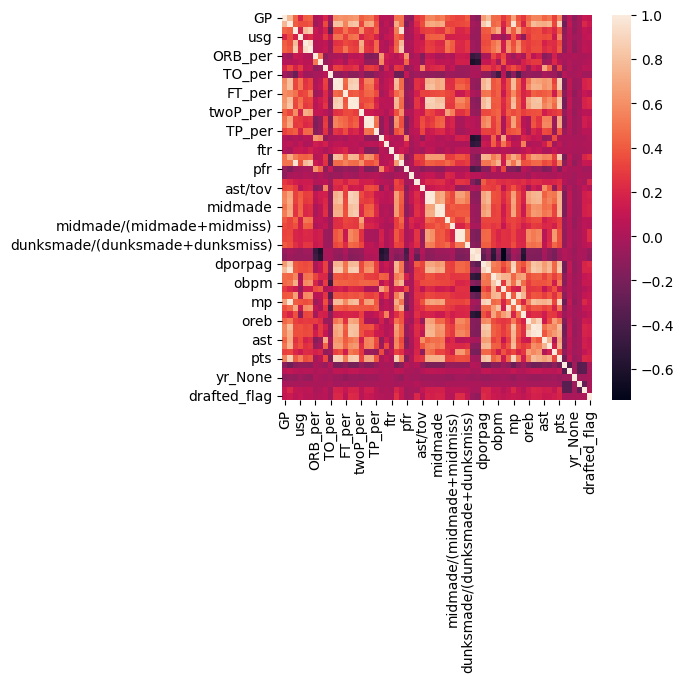

In [27]:
# plot settings
plt.rcParams['figure.figsize']=(5,5)

# heatmap of the correlations
sns.heatmap(df.corr(),annot=False)

Plot the histogram of the target feature.

<AxesSubplot: xlabel='drafted_flag', ylabel='Count'>

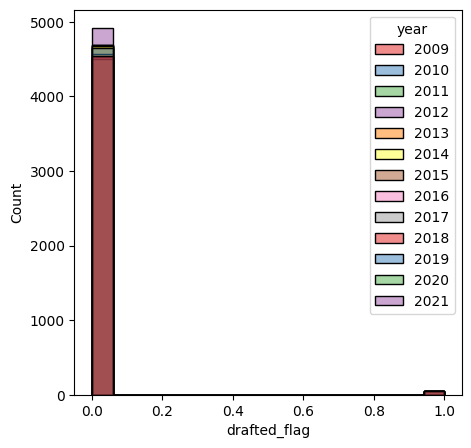

In [28]:
sns.histplot(data=df, x="drafted_flag", hue="year",palette="Set1")

Check the ratio of the target feature labels.

In [29]:
df.drafted_flag.value_counts()

0    60459
1      602
Name: drafted_flag, dtype: int64

Check the correlations with the highest absolute value between the target feature and the predictors.

In [30]:
drafted_corr_matrix = corr_matrix[corr_matrix.Variable1 == 'drafted_flag'].sort_values(by='Correlation',ascending=False)
print(drafted_corr_matrix.sort_values(by='Correlation',ascending=False))

         Variable1                        Variable2  Correlation
3622  drafted_flag                           porpag     0.250765
3634  drafted_flag                        dunksmade     0.227100
3635  drafted_flag              dunksmiss+dunksmade     0.223806
3639  drafted_flag                          dporpag     0.221672
3613  drafted_flag                            twoPM     0.219013
3610  drafted_flag                              FTM     0.210367
3611  drafted_flag                              FTA     0.204868
3614  drafted_flag                            twoPA     0.204032
3626  drafted_flag                         Rec Rank     0.200200
3654  drafted_flag                              pts     0.191454
3630  drafted_flag                          midmade     0.188799
3640  drafted_flag                            stops     0.186134
3631  drafted_flag                  midmade+midmiss     0.185105
3628  drafted_flag                          rimmade     0.182256
3649  drafted_flag       

### 5. Random model creation

Use the empirical distribution of the drafted flag feature to create a random model predicting the drafted players (Bernoulli distribution).

In [31]:
from scipy.stats import bernoulli

# probability of drafted flag = 1
prob_drafted = np.average(yearly_drafts)

# random model with the given Bernoulli distribution with the length of
rand_model = pd.DataFrame(data=[bernoulli(prob_drafted).rvs(len(df))])
rand_model = rand_model.transpose()
rand_model.columns = ['pred_drafted_flag']

print(rand_model.value_counts())

pred_drafted_flag
0                    60509
1                      552
dtype: int64


### 6. Random model evaluation

In [32]:
# evaluate the random model
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)
cp = classification_report(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)
print(cm, cp, sep='\n')

[[59912   547]
 [  597     5]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     60459
           1       0.01      0.01      0.01       602

    accuracy                           0.98     61061
   macro avg       0.50      0.50      0.50     61061
weighted avg       0.98      0.98      0.98     61061

